In [1]:
import wave
import gc
import random
import librosa
import librosa.display
import IPython
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.client import device_lib

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/urbansound8k/UrbanSound8K.csv")
df['class'].value_counts()

jackhammer          1000
children_playing    1000
engine_idling       1000
street_music        1000
drilling            1000
dog_bark            1000
air_conditioner     1000
siren                928
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [ ]:
XXlabel=np.array(Ylabel)
print(len(Ylabel))
XXXlabel=[]
for k in Ylabel:
  for j in k:
    XXXlabel.append(j)
XX=np.array(XXXlabel)
Ynewlabel=XX
print(len(Ynewlabel))
np.save("/content/drive/MyDrive/urbansound8k/newspec/train/Ylabel.npy",Ynewlabel)

7
2320


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
#RUN FROM DOWN HERE 

In [5]:
Xtrain=np.load("/content/drive/MyDrive/urbansound8k/newspec/train/Xlabel.npy")
Ytrain=np.load("/content/drive/MyDrive/urbansound8k/newspec/train/Ylabel.npy")
Xunlabel=np.load("/content/drive/MyDrive/urbansound8k/newspec/train/Xunlabel.npy")
Yunlabel=np.load("/content/drive/MyDrive/urbansound8k/newspec/train/Yunlabel.npy")

In [ ]:
Yunlabel

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
print(torch.cuda.is_available())

True


In [6]:
def extract_sample(n_way, n_support,n_unlabel, n_query, datax, datay,dataunlabelx,dataunlabely):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  sample_unlabel=[]
  K = np.random.choice(np.unique(datay),n_way, replace = False)
  #print(np.unique(datay))
  #print(K)
  for cls in K:
    datax_cls = datax[datay == cls]
    datax_cls_unlabel=dataunlabelx[dataunlabely == cls]
    perm = np.random.permutation(datax_cls)
    permunlabel = np.random.permutation(datax_cls_unlabel)
    sample_cls = perm[:(n_support+n_query)]
    sample_cls_unlabel=permunlabel[:n_unlabel]
    sample_unlabel.append(sample_cls_unlabel)
    sample.append(sample_cls)
  sample = np.array(sample)
  #print(sample)
  sample_unlabel=np.array(sample_unlabel)
  sample = torch.from_numpy(sample).float()
  sample_unlabel=torch.from_numpy(sample_unlabel).float()
  sample = sample.permute(0,1,4,2,3)
  sample_unlabel = sample_unlabel.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_unlabel':n_unlabel,
      'n_query': n_query,
      'unlabelimages':sample_unlabel
      })

In [7]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:+
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (10,7))
  plt.imshow(out.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


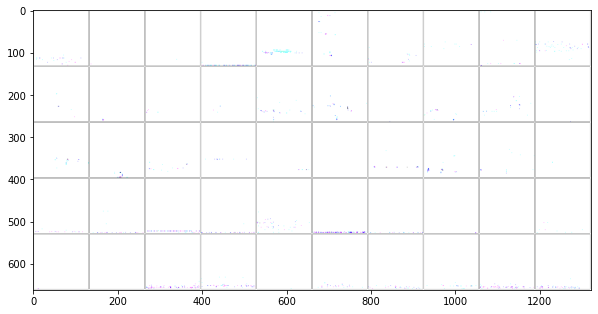

In [8]:
sample_example = extract_sample(5, 5, 5, 5,Xtrain, Ytrain, Xunlabel,Yunlabel)
display_sample(sample_example['images'])
# Ytrain.shape

In [9]:


class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']
  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2))
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten())
  return ProtoNet(encoder)

In [10]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    sample_unlabel=sample['unlabelimages'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']
    
    n_unlabel=sample['n_query']
    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
    x_unlabel=sample_unlabel[:, :n_unlabel]
    #print(x_support)
    #print(x_unlabel.shape)
    #target indices are 0 ... n_way-1
    
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
    #print(target_inds)
    ########################FOR UNLABELLED SET 
    xun=torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:])
                  ,x_unlabel.contiguous().view(n_way * n_unlabel, *x_unlabel.size()[2:])],0)
    zun = self.encoder.forward(xun)
    zun_dim = zun.size(-1)
    #print(zun_dim)
    #print(zun.shape)
    zun_protostar = zun[:n_way*n_support].view(n_way, n_support, zun_dim).mean(1)
    zun_protostarcopy=zun[:n_way*n_support].view(n_way, n_support, zun_dim).mean(1)
    #zun_unlabelquery = zun[n_way*n_unlabel:]   #####GALAT LIKHA THA
    zun_unlabelquery = zun[n_way*n_support:]
    name=zun_unlabelquery.view(n_way, n_support, zun_dim)
    distsstar = euclidean_dist(zun_unlabelquery, zun_protostar) 
    #log_p_ystar = F.log_softmax(-distsstar,dim=1).view(n_way, n_support, -1) ### GALAT THA
    log_p_ystar = F.log_softmax(-distsstar,dim=1).view(n_way, n_unlabel, -1)
    loss_valstar = -log_p_ystar.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_ystar.max(2)
    #print(y_hat)
    acc_valold1 = torch.eq(y_hat, target_inds.squeeze()).float().mean()
    prototype=losss(y_hat,x_unlabel,name,zun_dim,n_way,zun_protostarcopy,n_support)
    ##################FOR UNLABELLEDSET+SUPPORT SET PROTOTYPE FOUND---> now using new prototype for the calculation
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
    z=self.encoder.forward(x)
    z_query = z[n_way*n_support:] #for query set ## YAHA BHI GALAT THA PAR DOESNT MATTER HERE KYUNKI SAB 5 LIA hai baadme karega afferct
    ####FOR QUERY SET WITHOUT UNLABELED
    distold=euclidean_dist(z_query,zun_protostar)# old prototype
    #log_p_ystarold = F.log_softmax(-distold,dim=1).view(n_way, n_support, -1) ### GALAT THA
    log_p_ystarold = F.log_softmax(-distold,dim=1).view(n_way, n_query, -1)
    loss_valold = -log_p_ystarold.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hatold = log_p_ystarold.max(2)
    acc_valold = torch.eq(y_hatold, target_inds.squeeze()).float().mean()
    print("accuracy on query set without adding unlabeled")
    print(acc_valold)
    # print(prototype)
    #### END OF QUERY SET WITHOUT UNLABELED
    #### FOR QUERY SET WITH UNLABELED
    dists = euclidean_dist(z_query, prototype) # distance between query and new prototype
    log_p_ystar = F.log_softmax(-dists,dim=1).view(n_way, n_support, -1)
    loss_val = -log_p_ystar.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hatfinal = log_p_ystar.max(2)
    acc_val = torch.eq(y_hatfinal, target_inds.squeeze()).float().mean()
    #print(target_inds.squeeze())
    print(acc_val)
     #### FOR END OF QUERY SET WITH UNLABELED
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hatfinal
        }

In [11]:
#making of new prototype
def losss(y_hat,x_unlabel,name,zdim,n_way,zun_protostarcopy,n_support):
  ar=torch.zeros(n_way,zdim).cuda()
  j1=0
  sizearray=torch.zeros(n_way)
  p=0
  for j1 in range(n_way):
    zun_protostarcopy[p]=zun_protostarcopy[p]*n_support
    #print(len(zun_protostarcopy[p]))
    sizearray[p]=sizearray[p]+n_support
    p=p+1
  j=0
  #print(y_hat)
  for k in y_hat:
    i=0
    for kk in k:
      #print(zun_protostarcopy[kk])
      #print(name[j][i])
      zun_protostarcopy[kk]=zun_protostarcopy[kk]+name[j][i]
      sizearray[kk]=int(sizearray[kk])+1
      i=i+1
    j=j+1
  k=0
  for l in sizearray:
    zun_protostarcopy[k]=zun_protostarcopy[k]/l
    k=k+1
  return zun_protostarcopy

In [12]:
######


In [13]:

def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

In [14]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [15]:


def train(model, optimizer, train_x, train_y, n_way, n_support,n_unlabel, n_query, max_epoch, epoch_size,Xunlabel,Yunlabel):
  """
  Trains the protonet
  Args:
      model
      
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support,n_unlabel, n_query, train_x, train_y,Xunlabel,Yunlabel)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()
    

In [ ]:
%%time
import torch
from tensorflow import keras
model = load_protonet_conv(
    x_dim=(4,130,130),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)
n_way = 5
n_support = 5
n_query = 5
n_unlabel= 5
train_x = Xtrain
train_y = Ytrain
max_epoch = 10
epoch_size = 2000

train(model, optimizer, train_x, train_y, n_way, n_support, n_unlabel, n_query, max_epoch, epoch_size,Xunlabel,Yunlabel)
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.save(model,"/content/drive/MyDrive/urbansound8k/bestmodel.pt")
# model.save()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Streaming output truncated to the last 5000 lines.
accuracy on query set without adding unlabeled
tensor(0.7600, device='cuda:0')
tensor(0.7600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.6000, device='cuda:0')
tensor(0.5600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.8400, device='cuda:0')
tensor(0.8800, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.6400, device='cuda:0')
tensor(0.7200, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.6800, device='cuda:0')
tensor(0.5600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.7200, device='cuda:0')
tensor(0.7200, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.6800, device='cuda:0')
tensor(0.6800, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.7600, device='cuda:0')
tensor(0.8000, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.7600,

Streaming output truncated to the last 5000 lines.
accuracy on query set without adding unlabeled
tensor(0.9600, device='cuda:0')
tensor(0.9600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.8400, device='cuda:0')
tensor(0.8000, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.8800, device='cuda:0')
tensor(0.9600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.8400, device='cuda:0')
tensor(0.8000, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9200, device='cuda:0')
tensor(0.9600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.8800, device='cuda:0')
tensor(0.9200, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.7200, device='cuda:0')
tensor(0.8000, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.8800, device='cuda:0')
tensor(0.9200, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.6800,

Streaming output truncated to the last 5000 lines.
accuracy on query set without adding unlabeled
tensor(0.9600, device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9200, device='cuda:0')
tensor(0.9600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9600, device='cuda:0')
tensor(0.9600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.8400, device='cuda:0')
tensor(0.9200, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9200, device='cuda:0')
tensor(0.8800, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9200, device='cuda:0')
tensor(0.8800, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9600, device='cuda:0')
tensor(0.9600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9600, device='cud

Streaming output truncated to the last 5000 lines.
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9200, device='cuda:0')
tensor(0.9600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9200, device='cuda:0')
tensor(0.9200, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9200, device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9600, device='cuda:0')
tensor(0.9600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cud

Streaming output truncated to the last 5000 lines.
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9200, device='cuda:0')
tensor(0.9200, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9600, device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy o

Streaming output truncated to the last 5000 lines.
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set 

Streaming output truncated to the last 5000 lines.
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(0.9600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query 

Streaming output truncated to the last 5000 lines.
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(0.9600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query 

Streaming output truncated to the last 5000 lines.
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(0.9600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query 

Streaming output truncated to the last 5000 lines.
tensor(0.9600, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.9600, device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
accuracy on query set without adding unlabeled
tensor(1., device='cuda:0')
tensor(1., dev

TESTING

In [17]:
# torch.save(model,"/content/drive/MyDrive/urbansound8k/bestacctill.pt")
model=torch.load("/content/drive/MyDrive/urbansound8k/bestacctill.pt")

In [ ]:
def extract_sample_test(n_way, n_support,n_unlabel, n_query, datax, datay):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  K = np.random.choice(np.unique(datay),n_way)
  print(K)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_unlabel':n_unlabel,
      'n_query': n_query
      })

In [19]:
##TESTTTTTTINGGG NEW
def test(model, test_x, test_y, n_way, n_support,n_unlabel, n_query, test_episode,Xunlabel,Yunlabel):
  
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support,n_unlabel, n_query, test_x, test_y,Xunlabel,Yunlabel)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [ ]:
##TESTTTTTTINGGG OLDDD
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample_test(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [18]:
Xunlabeltest = np.load('/content/drive/MyDrive/urbansound8k/newspec/test/Xunlabeltest.npy')
Yunlabeltest = np.load('/content/drive/MyDrive/urbansound8k/newspec/test/Yunlabeltest.npy')
Xtest = np.load('/content/drive/MyDrive/urbansound8k/newspec/test/Xlabeltest.npy')
Ytest = np.load('/content/drive/MyDrive/urbansound8k/newspec/test/Ylabeltest.npy')

In [22]:
n_way = 3
n_support = 3
n_query = 3
n_unlabel=3
test_x = Xtest
test_y = Ytest
test_episode = 1000
test(model, test_x, test_y, n_way, n_support,n_unlabel, n_query, test_episode,Xunlabeltest,Yunlabeltest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


accuracy on query set without adding unlabeled
tensor(0.4444, device='cuda:0')
tensor(0.4444, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.7778, device='cuda:0')
tensor(0.5556, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.6667, device='cuda:0')
tensor(0.6667, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.8889, device='cuda:0')
tensor(0.6667, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.6667, device='cuda:0')
tensor(0.6667, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.5556, device='cuda:0')
tensor(0.4444, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.8889, device='cuda:0')
tensor(0.8889, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.5556, device='cuda:0')
tensor(0.5556, device='cuda:0')
accuracy on query set without adding unlabeled
tensor(0.7778, device='cuda:0')
tensor(0.7778, device='cuda:0')
a

In [ ]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  print(sample.shape)
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

In [ ]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [ ]:
my_loss, my_output = model.set_forward_loss(my_sample)